# Prediction of permeability in basalts of the Serra Geral Group

- Joao Paulo G. R. Alves - 2024
- joao (dot) guilherme (dot) alves (at) usp (dot) br
- Institute of Energy and Environment - University of Sao Paulo
- This is the full research script, meaning some of the stuff her was not used in the final paper

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, KFold
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import PredictionErrorDisplay
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import gaussian_kde, pearsonr
import scipy.stats as stats
import statsmodels.api as sm
import os
import shap
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['mathtext.fontset'] = 'cm'

In [3]:
# Read data from Excel
df = pd.read_excel("rawdata_permeability.xlsx")
data = df[['density', 'vp', 'porosity', 'permeability']].copy()

In [4]:
# Transform permeability
data['permeability'] = np.log10(data['permeability'])

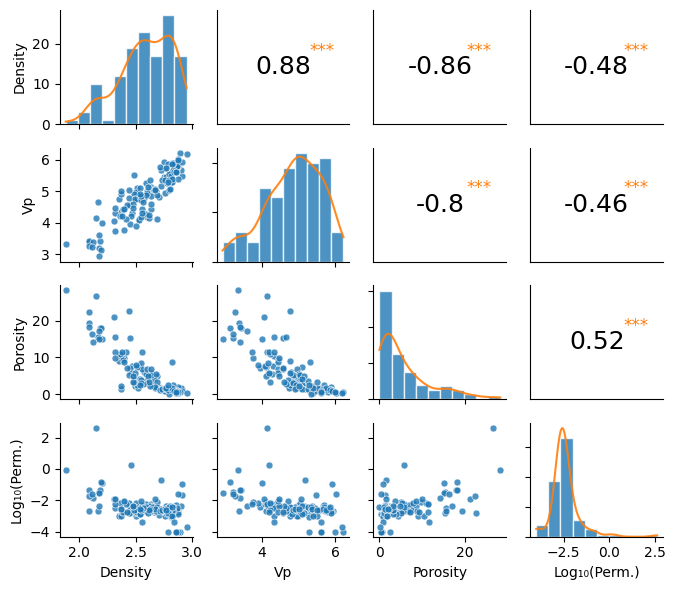

In [5]:
# EDA plot 
data.columns = ['Density', 'Vp', 'Porosity', 'Log10(Permeability)']

# corrdot function to plot correlation coefficient
def corrdot(x, y, ax=None, **kwargs):
    corr_r = x.corr(y, 'pearson')
    corr_text = round(corr_r, 2)
    if ax is not None:
        ax.annotate(corr_text, xy=(0.5, 0.5), xycoords="axes fraction",
                    ha='center', va='center', fontsize=18)

# corrfunc function to plot significance stars
def corrfunc(x, y, ax=None, **kws):
    r, p = stats.pearsonr(x, y)
    p_stars = ''
    if p <= 0.05: p_stars = '*'
    if p <= 0.01: p_stars = '**'
    if p <= 0.001: p_stars = '***'
    if ax is not None:
        ax.annotate(p_stars, xy=(0.7, 0.6), xycoords="axes fraction",
                    color='tab:orange', fontsize=12) 

n = len(data.columns)

# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(7, 6))

# Plot each pair of variables
for i in range(n):
    for j in range(n):
        ax = axs[i, j]
        if i == j:  # Diagonal plot with histogram and KDE
             # Histogram without density normalization
            counts, bins, patches = axs[i, j].hist(data[data.columns[i]], bins=10, color='tab:blue', alpha = 0.8, edgecolor='white')
            if j == 0:
                axs[i, j].xaxis.set_ticklabels([])
            elif j == n-1:
                axs[i, j].yaxis.set_ticklabels([])
            else:
                axs[i, j].xaxis.set_ticklabels([])
                axs[i, j].yaxis.set_ticklabels([])
            # KDE
            kde = gaussian_kde(data[data.columns[i]])
            x_range = np.linspace(bins.min(), bins.max(), 100)

            # Scale KDE by the count to match histogram scale
            kde_values = kde(x_range) * sum(counts) * np.diff(bins)[0]

            axs[i, j].plot(x_range, kde_values, color='tab:orange', alpha = 0.9)
            
        elif j > i:
            # Correctly pass the axis to the functions
            corrdot(data[data.columns[i]], data[data.columns[j]], ax=ax)
            corrfunc(data[data.columns[i]], data[data.columns[j]], ax=ax)
            axs[i, j].set_facecolor('white')
            for spine in axs[i, j].spines.values():
                spine.set_visible(True)
                spine.set_color('black')
            axs[i, j].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
        else:
            axs[i, j].scatter(data[data.columns[j]], data[data.columns[i]], color='tab:blue', 
                              edgecolor='white', alpha=0.8, linewidth=0.5, s = 25)

        # Add labels to the leftmost and bottom subplots
        if i == n - 1:
            if data.columns[j] == 'Log10(Permeability)':
                axs[i, j].set_xlabel('Log₁₀(Perm.)')
            else:
                axs[i, j].set_xlabel(data.columns[j])
                
        if j == 0:
            if data.columns[i] == 'Log10(Permeability)':
                axs[i, j].set_ylabel('Log₁₀(Perm.)')  # LaTeX for y-axis label
            else:
                axs[i, j].set_ylabel(data.columns[i])
                
        axs[i, j].spines[['right', 'top']].set_visible(False)

        if i == n-1 and j != 0:
            axs[i, j].yaxis.set_ticklabels([])

        if j == 0 and i != n-1:
            axs[i, j].xaxis.set_ticklabels([])

        if i != n-1 and j != 0:
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
        
plt.tight_layout()
plt.show()

In [6]:
data.head()

,Density,Vp,Porosity,Log10(Permeability)
0,2.573227,4.799273,6.083408,-2.703059
1,2.471437,4.316942,7.667464,-2.468521
2,2.447632,3.964627,7.219076,-2.408223
3,2.602406,4.182352,5.566899,-2.469041
4,2.526487,4.128584,7.447569,-2.709423


In [7]:
# Split into X-y
X = data.drop(columns = ['Log10(Permeability)'])
y = data['Log10(Permeability)']

In [8]:
# Split into train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [9]:
# Function to preprocess a dataframe
def preprocess_data(X, scaler=None, vp_dens_scaler=None):
    # Apply transformations
    X_transformed = X.copy()
    X_transformed['Porosity'] = np.sqrt(X_transformed['Porosity'])
    X_transformed['Vp'] = np.sqrt(np.max(X_transformed['Vp'] + 1) - X_transformed['Vp'])
        
    # Initialize MinMaxScaler for the main transformations if not provided
    if scaler is None:
        scaler = MinMaxScaler()
        scaler.fit(X_transformed)  # Fit scaler to the data
        X_scaled = scaler.transform(X_transformed)
    else:
        X_scaled = scaler.transform(X_transformed)  # Transform data using the existing scaler
    
    # Convert the scaled array back to a DataFrame
    X_scaled_df = pd.DataFrame(X_scaled, columns=X_transformed.columns, index=X_transformed.index)
    X_scaled_df['vp_dens'] = (X_scaled_df['Vp'] * X_scaled_df['Density']) ** 2

    # Initialize MinMaxScaler for 'vp_dens' if not provided
    if vp_dens_scaler is None:
        vp_dens_scaler = MinMaxScaler()
        vp_dens_scaler.fit(X_scaled_df[['vp_dens']])  # Fit scaler to 'vp_dens'
        X_scaled_df['vp_dens'] = vp_dens_scaler.transform(X_scaled_df[['vp_dens']])
    else:
        X_scaled_df['vp_dens'] = vp_dens_scaler.transform(X_scaled_df[['vp_dens']])  # Transform 'vp_dens' using the existing scaler

    return X_scaled_df, scaler, vp_dens_scaler

In [10]:
# Preprocess the training data
X_train_transformed, scaler, scaler1 = preprocess_data(X_train)

In [11]:
# Preprocess the test data using the scaler fitted on the training data
X_test_transformed, _, _ = preprocess_data(X_test, scaler, scaler1)

In [12]:
# Criteria for weights
some_threshold = 0.5  
high_weight = 2  # Weight for values above the threshold
low_weight = 1  # Weight for values below the threshold

sample_weights = np.where(y_train < some_threshold, low_weight, high_weight)

In [13]:
# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

In [14]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [15]:
cv_strategy = KFold(n_splits=10, shuffle=True, random_state=42)

In [16]:
# Perform grid search
grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=cv_strategy, 
                           n_jobs=-1, 
                           verbose=2, 
                           scoring='neg_root_mean_squared_error')

In [17]:
# Perform grid search
grid_search.fit(X_train_transformed, y_train, sample_weight=sample_weights);

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


In [18]:
# Display the best parameters
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [19]:
# Use the best estimator for further predictions
best_rf_model = grid_search.best_estimator_

In [20]:
# Predict with the tuned model
rf_predictions_tuned = best_rf_model.predict(X_test_transformed)

In [21]:
# Function to calculate and print metrics
def print_metrics(predictions, y_test, model_name):
    r2 = r2_score(y_test, predictions)
    rmse = root_mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    print(f"{model_name} - R2: {r2:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

In [22]:
print_metrics(rf_predictions_tuned, y_test, "Tuned Random Forest")

Tuned Random Forest - R2: 0.66, RMSE: 0.39, MAE: 0.30


In [23]:
def plot_learning_curves_on_ax(ax, estimator, title, X, y, cv, n_jobs=-1):
    """
    Generate a plot of the test and training learning curves on a given ax.
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, 
        scoring='neg_root_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10)
    )
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot the mean scores
    ax.plot(train_sizes, train_scores_mean, 'o-', color="tab:blue", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="tab:orange", label="Cross-validation score")

    # Plot the standard deviation
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="tab:blue")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="tab:orange")
                     
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Training Examples", fontsize=10)
    ax.set_ylabel("Root Mean Squared Error (RMSE)", fontsize=10)
    ax.legend(loc="upper right", fontsize=10)

In [24]:
# Create XAI
explainer = shap.TreeExplainer(best_rf_model)

In [25]:
# Preprocess the full dataset without fitting the scaler again
X_full_transformed, _, _ = preprocess_data(X, scaler, scaler1)

In [26]:
# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_full_transformed)

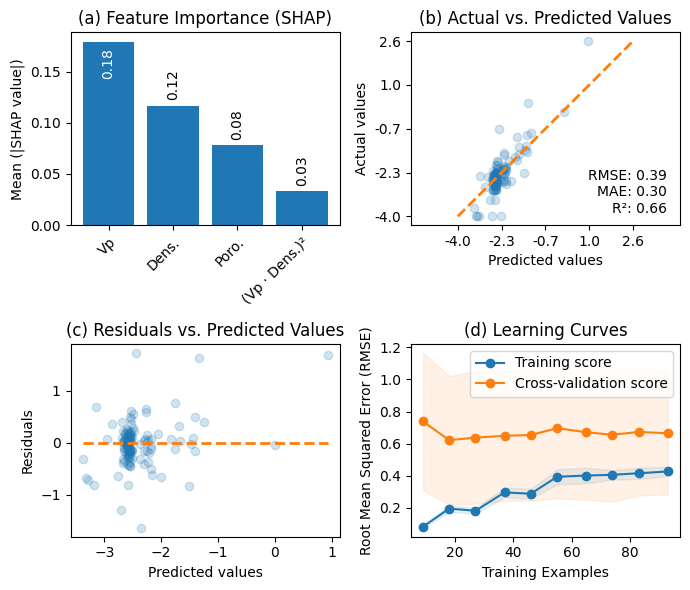

In [27]:
# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Sort the features by mean absolute SHAP value
sorted_indices = np.argsort(mean_abs_shap_values)[::-1]
sorted_features = X_full_transformed.columns[sorted_indices]
sorted_mean_abs_shap_values = mean_abs_shap_values[sorted_indices]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7, 6))
axs = axs.flatten()

# Plotting mean absolute SHAP values
bars = axs[0].bar(sorted_features, sorted_mean_abs_shap_values, color='tab:blue')
axs[0].set_xticklabels(['Vp', 'Dens.', 'Poro.', '(Vp \u00B7 Dens.)\u00B2', 'Poro/vp'], rotation=45, ha='right', rotation_mode="anchor")
axs[0].set_ylabel("Mean (|SHAP value|)")
axs[0].set_title("(a) Feature Importance (SHAP)", fontsize=12)

# Adding text to each bar for SHAP values
for idx, bar in enumerate(bars):
    height = bar.get_height()
    if idx == 0:  #First bar
        axs[0].text(bar.get_x() + bar.get_width()/2., 0.88*height, 
                    '%.2f' % float(height), ha='center', va='center', 
                    color='white', rotation=90, fontweight='normal')
    else:  #Other bars
        axs[0].text(bar.get_x() + bar.get_width()/2., height+0.005,  
                    '%.2f' % float(height), ha='center', va='bottom', 
                    color='black', rotation=90, fontweight='normal')

# Prediction Error Display - Actual vs Predicted
ped_actual_vs_predicted = PredictionErrorDisplay.from_estimator(
    best_rf_model, X_full_transformed, y, kind="actual_vs_predicted", ax=axs[1],
    scatter_kwargs={"alpha": 0.2, "color": 'tab:blue'}, line_kwargs={"alpha": 1, "color": 'tab:orange', "linewidth": 2}
)
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axs[1].set_title("(b) Actual vs. Predicted Values", fontsize=12)

# Calculate metrics
rmse_val = root_mean_squared_error(y_test, best_rf_model.predict(X_test_transformed))
mae_val = mean_absolute_error(y_test, best_rf_model.predict(X_test_transformed))
r2_val = r2_score(y_test, best_rf_model.predict(X_test_transformed))

# Adding RMSE, MAE, R^2 text in the lower right
axs[1].text(0.95, 0.05, f'RMSE: {rmse_val:.2f}\nMAE: {mae_val:.2f}\nR²: {r2_val:.2f}', 
            transform=axs[1].transAxes, verticalalignment='bottom', horizontalalignment='right')

# Prediction Error Display - Residual vs Predicted
ped_residual_vs_predicted = PredictionErrorDisplay.from_estimator(
    best_rf_model, X_full_transformed, y, kind="residual_vs_predicted", ax=axs[2],
    scatter_kwargs={"alpha": 0.2, "color": 'tab:blue'}, line_kwargs={"alpha": 1, "color": 'tab:orange', "linewidth": 2}
)
axs[2].set_ylabel("Residuals")
axs[2].set_title("(c) Residuals vs. Predicted Values", fontsize=12)

# Learning curves
plot_learning_curves_on_ax(
    ax=axs[3],
    estimator=best_rf_model,  
    title="(d) Learning Curves", 
    X=X_train_transformed, 
    y=y_train, 
    cv=cv_strategy
)

plt.tight_layout()
plt.show()

In [28]:
# Perform LOWESS smoothing
def lowess_smoothing(x, y, frac=0.1):
    return sm.nonparametric.lowess(y, x, frac=frac)

# Bootstrap function for LOWESS confidence intervals
def bootstrap_lowess_ci(x, y, frac=0.1, n_boot=100, ci=95):
    # Store bootstrapped lowess curves
    boot_lowess_curves = np.zeros((n_boot, len(x)))
    
    for i in range(n_boot):
        # Resample with replacement
        indices = np.random.choice(range(len(x)), size=len(x), replace=True)
        x_resampled, y_resampled = x[indices], y[indices]
        
        # LOWESS smoothing on resampled data
        lowess_resampled = lowess_smoothing(x_resampled, y_resampled, frac=frac)
        
        # Sort by x to keep the curve order
        sorted_indices = np.argsort(lowess_resampled[:, 0])
        boot_lowess_curves[i] = lowess_resampled[sorted_indices, 1]
    
    # Calculate percentiles for confidence intervals
    lower_bound = np.percentile(boot_lowess_curves, (100 - ci) / 2., axis=0)
    upper_bound = np.percentile(boot_lowess_curves, 100 - (100 - ci) / 2., axis=0)
    
    return lower_bound, upper_bound

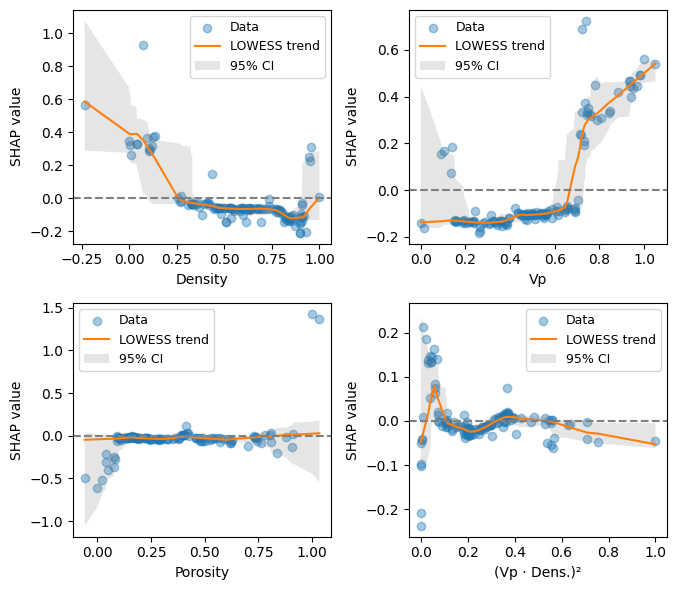

In [29]:
# Partial Plots

original_features = X_full_transformed.columns.to_list()

renamed_features = ['Density', 'Vp', 'Porosity', '(Vp \u00B7 Dens.)\u00B2']

# fill_kwargs
fbk = {'lw':0.0, 'edgecolor':None}

fig, axes = plt.subplots(2, 2, figsize=(7, 6))
axes = axes.flatten()  # Flatten the 2x2 grid into a 1D array for easier indexing

# Loop through each original feature name and its corresponding new name
for idx, (original_feature_name, renamed_feature_name) in enumerate(zip(original_features, renamed_features)):
    # Extract SHAP values for the specific feature
    if isinstance(shap_values, list):
        shap_values_for_feature = shap_values[0][:, X_full_transformed.columns.get_loc(original_feature_name)]
    else:
        shap_values_for_feature = shap_values[:, X_full_transformed.columns.get_loc(original_feature_name)]

    # Original LOWESS smoothing
    lowess_original = lowess_smoothing(X_full_transformed[original_feature_name], shap_values_for_feature, frac=0.2)

    # Calculate confidence intervals via bootstrapping
    lower_bound, upper_bound = bootstrap_lowess_ci(X_full_transformed[original_feature_name].values, shap_values_for_feature, frac=0.2, n_boot=100, ci=95)

    # Plotting for the current feature
    ax = axes[idx]
    scatter = ax.scatter(X_full_transformed[original_feature_name], shap_values_for_feature, alpha=0.4, label='Data', color='tab:blue')
    line = ax.plot(lowess_original[:, 0], lowess_original[:, 1], color="tab:orange", label='LOWESS trend')
    ci_fill = ax.fill_between(lowess_original[:, 0], lower_bound, upper_bound, color='tab:grey', alpha=0.2, label='95% CI', **fbk)
    hline = ax.axhline(y=0, color='grey', linestyle='--')
    ax.set_xlabel(renamed_feature_name)
    ax.set_ylabel('SHAP value')
    ax.legend(fontsize = 9)


# Option: Create a single legend for the entire figure
#fig.legend([scatter, line[0], ci_fill, hline], ['Data', 'LOWESS trend', '95% CI'], loc='upper center', bbox_to_anchor=(0.5, 0), ncol=4)

plt.tight_layout()
plt.show()

In [30]:
'''
# Predicting new data from other wells
directory = '/home/joao/Documents_Ubuntu/Projeto_DLISIO/Dados_Predicted_Dens_Poro'
directory_perm = '/home/joao/Documents_Ubuntu/Projeto_DLISIO/Dados_Predicted_Dens_Poro_Perm'
'''

"\n# Predicting new data from other wells\ndirectory = '/home/joao/Documents_Ubuntu/Projeto_DLISIO/Dados_Predicted_Dens_Poro'\ndirectory_perm = '/home/joao/Documents_Ubuntu/Projeto_DLISIO/Dados_Predicted_Dens_Poro_Perm'\n"

In [31]:
'''
for filename in os.listdir(directory):
    if filename.endswith(".xlsx"):
        file_path = os.path.join(directory, filename)
        data1 = pd.read_excel(file_path)
        X_original = data1.copy()

        X_new = data1.drop(columns=['depth', 'gr', 'sp', 'res', 'well'])
        X_new = X_new[['Density', 'dt', 'Porosity']]
        X_new.rename(columns={'dt':'Vp'}, inplace=True)
        X_new['Vp'] = (X_new['Vp']**(-1))*304.8

        X_new_transformed, _, _ = preprocess_data(X_new, scaler, scaler1)
        predictions_new = best_rf_model.predict(X_new_transformed)
        X_original['perm_md'] = 10**predictions_new
        X_original['perm_microd'] =  X_original['perm_md']*1000
        X_original['Vp'] = X_new['Vp']
        
        # Create a new filename by removing the extension and adding '_dens.xlsx'
        new_filename = filename[:-5] + '_perm.xlsx'  # Removes '.xlsx' and adds '_dens.xlsx'
        new_file_path = os.path.join(directory_perm, new_filename)

        # Save the updated DataFrame
        X_original.to_excel(new_file_path, index=False)
'''

'\nfor filename in os.listdir(directory):\n    if filename.endswith(".xlsx"):\n        file_path = os.path.join(directory, filename)\n        data1 = pd.read_excel(file_path)\n        X_original = data1.copy()\n\n        X_new = data1.drop(columns=[\'depth\', \'gr\', \'sp\', \'res\', \'well\'])\n        X_new = X_new[[\'Density\', \'dt\', \'Porosity\']]\n        X_new.rename(columns={\'dt\':\'Vp\'}, inplace=True)\n        X_new[\'Vp\'] = (X_new[\'Vp\']**(-1))*304.8\n\n        X_new_transformed, _, _ = preprocess_data(X_new, scaler, scaler1)\n        predictions_new = best_rf_model.predict(X_new_transformed)\n        X_original[\'perm_md\'] = 10**predictions_new\n        X_original[\'perm_microd\'] =  X_original[\'perm_md\']*1000\n        X_original[\'Vp\'] = X_new[\'Vp\']\n\n        # Create a new filename by removing the extension and adding \'_dens.xlsx\'\n        new_filename = filename[:-5] + \'_perm.xlsx\'  # Removes \'.xlsx\' and adds \'_dens.xlsx\'\n        new_file_path = os.pa